In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [ ]:
!kaggle datasets download -d izznfkhrlislm/carnoncar-dataset
!unzip carnoncar-dataset.zip -d carnoncar-dataset

Dataset URL: https://www.kaggle.com/datasets/izznfkhrlislm/carnoncar-dataset
License(s): unknown
carnoncar-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  carnoncar-dataset.zip
replace carnoncar-dataset/car_scaled/car_scaled/car_scaled_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


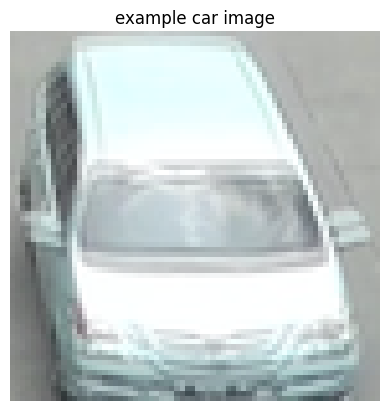

image dimension: (72, 72)


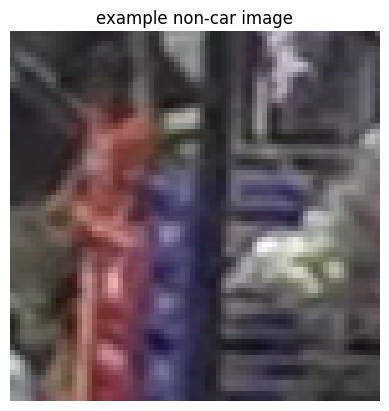

In [ ]:
car_dir = "carnoncar-dataset/car_scaled/car_scaled"
non_car_dir = "carnoncar-dataset/non_car_scaled/non_car_scaled"
# print some images
file_names = os.listdir(car_dir)
img_path = os.path.join(car_dir, file_names[4])
img = Image.open(img_path)
plt.figure()
plt.imshow(img)
plt.title(f"example car image")
plt.axis('off')
plt.show()
print(f"image dimension: {img.size}")
file_names = os.listdir(non_car_dir)
img_path = os.path.join(non_car_dir, file_names[0])
img = Image.open(img_path)
plt.figure()
plt.imshow(img)
plt.title(f"example non-car image")
plt.axis('off')
plt.show()


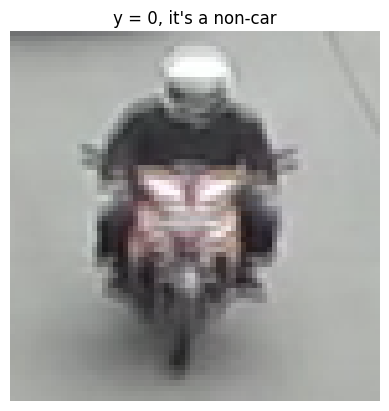

Training Examples: 168
Test Examples: 43
Image Dimensions: 72x72
Train Data Shape: (168, 72, 72, 4)
Train Labels Shape: (1, 168)

After preprocessing:
Flattened Train Shape: (20736, 168)
Flattened Test Shape: (20736, 43)


In [ ]:
# Load dataset directories
car_dir = "carnoncar-dataset/car_scaled/car_scaled"
non_car_dir = "carnoncar-dataset/non_car_scaled/non_car_scaled"

# Function to load images and labels
def load_dataset(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        images.append(img_array)

    labels = [label] * len(images)

    return images, labels

# Load car and non-car images
car_images, car_labels = load_dataset(car_dir, 1)
non_car_images, non_car_labels = load_dataset(non_car_dir, 0)

# Combine and shuffle data
X = np.array(car_images + non_car_images)
Y = np.array(car_labels + non_car_labels)

# Shuffle dataset
m = X.shape[0]
indices = np.random.permutation(m)
X = X[indices]
Y = Y[indices]

# Split into train/test (80/20)
split = int(m * 0.8)
train_set_x_orig = X[:split]
train_set_y = Y[:split].reshape(1, -1)  # Shape (1, m_train)
test_set_x_orig = X[split:]
test_set_y = Y[split:].reshape(1, -1)   # Shape (1, m_test)

# Define classes
classes = ['non-car', 'car']

# Example image from training set
index = 25
plt.imshow(train_set_x_orig[index])
plt.title(f"y = {train_set_y[0, index]}, it's a {classes[train_set_y[0, index]]}")
plt.axis('off')
plt.show()

# Dataset statistics
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]  # Assuming square images

print(f"Training Examples: {m_train}")
print(f"Test Examples: {m_test}")
print(f"Image Dimensions: {num_px}x{num_px}")
print(f"Train Data Shape: {train_set_x_orig.shape}")
print(f"Train Labels Shape: {train_set_y.shape}")

# Flatten and normalize images
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

print("\nAfter preprocessing:")
print(f"Flattened Train Shape: {train_set_x.shape}")
print(f"Flattened Test Shape: {test_set_x.shape}")

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))

    return s

# test the sigmoid function
x = np.array([1, 2, 3])
assert np.allclose(sigmoid(x), np.array([0.73105858, 0.88079708, 0.95257413])), "Wrong output"


def tanh(z):
    """
    Compute the tanh of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- tanh(z)

    """
    s = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

    return s

In [ ]:
def initialize_with_zeros(dim):
    """
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros(shape=(dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b


# test the initialize_with_zeros function
dim = 2
w, b = initialize_with_zeros(dim)
assert w.shape == (dim, 1), "Wrong shape"
assert np.all(w == 0), "Wrong values"

In [ ]:
def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """

    m = X.shape[1]

    # FORWARD PROPAGATION
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))

    # BACKWARD PROPAGATION
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

# test
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
assert np.all(np.isclose(grads["dw"], np.array([[ 0.99993216],[ 1.99980262]]))), "Wrong values for dw"
assert np.isclose(grads["db"], 0.499935230625), "Wrong value for db"
assert(np.isclose(cost, 6.000064773192205)), "Wrong value for cost"

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db


        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs


# test optimize
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

#EXPECTED:
#b 1.55930492484

# **dw**
# [[ 0.90158428]
# [ 1.76250842]]

# **w**	[[ 0.1124579 ] [ 0.23106775]]

# db	0.430462071679

assert np.all(np.isclose(params["w"], np.array([[ 0.1124579 ],[ 0.23106775]]))), "Wrong values for w"
assert np.isclose(params["b"], 1.55930492484), "Wrong value for b"
assert np.all(np.isclose(grads["dw"], np.array([[ 0.90158428],[ 1.76250842]]))), "Wrong values for dw"
assert np.isclose(grads["db"], 0.430462071679), "Wrong value for db"


In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

# Test
print("predictions = " + str(predict(w, b, X)))
#expected predictions = [[ 1.  1.]]
assert np.all(predict(w, b, X) == np.array([[ 1.,  1.]])), "Wrong predictions"

predictions = [[1. 1.]]


In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [ ]:
# timestamp
import time
start = time.time()
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.01, print_cost = True)
end = time.time()
print(f"Time taken for model training: {end - start} seconds")

Cost after iteration 0: 0.693147


<ipython-input-73-4eb88f9c71a3>:19: RuntimeWarning: divide by zero encountered in log
  cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost
<ipython-input-73-4eb88f9c71a3>:19: RuntimeWarning: invalid value encountered in multiply
  cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost


Cost after iteration 100: 0.172414
Cost after iteration 200: 0.075674
Cost after iteration 300: 0.042492
Cost after iteration 400: 0.031816
Cost after iteration 500: 0.026479
Cost after iteration 600: 0.022930
Cost after iteration 700: 0.020307
Cost after iteration 800: 0.018264
Cost after iteration 900: 0.016619
Cost after iteration 1000: 0.015260
Cost after iteration 1100: 0.014116
Cost after iteration 1200: 0.013137
Cost after iteration 1300: 0.012290
Cost after iteration 1400: 0.011549
Cost after iteration 1500: 0.010894
Cost after iteration 1600: 0.010311
Cost after iteration 1700: 0.009789
Cost after iteration 1800: 0.009318
Cost after iteration 1900: 0.008890
train accuracy: 100.0 %
test accuracy: 95.34883720930233 %
Time taken for model training: 10.768696546554565 seconds


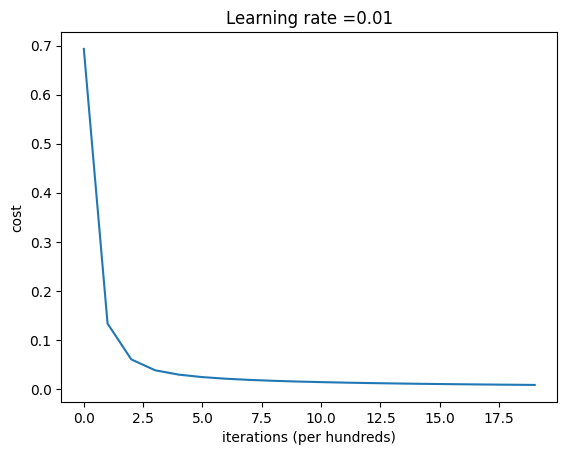

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01


<ipython-input-24-5ed4a3055ff6>:24: RuntimeWarning: divide by zero encountered in log
  cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost
<ipython-input-24-5ed4a3055ff6>:24: RuntimeWarning: invalid value encountered in multiply
  cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # compute cost


train accuracy: 100.0 %
test accuracy: 95.34883720930233 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 97.61904761904762 %
test accuracy: 95.34883720930233 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 94.04761904761905 %
test accuracy: 93.02325581395348 %

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 100.0 %
test accuracy: 97.67441860465117 %

-------------------------------------------------------



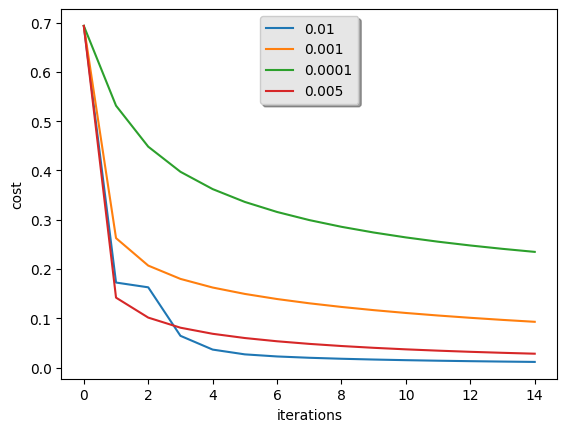

In [ ]:
learning_rates = [0.01, 0.001, 0.0001, 0.005]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

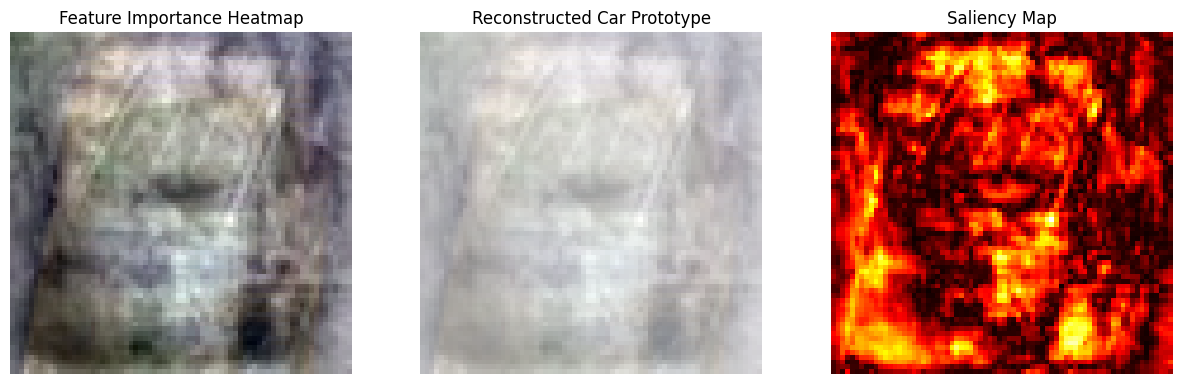

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.special

def sigmoid(x):
    return scipy.special.expit(x)

def visualize_learned_car(w, b, image_shape=(72, 72, 4)):
    """
    Generate visualizations of learned features for the car classification model.
    """
    w_reshaped = w.reshape(image_shape)  # Reshape weights back to image form
    w_normalized = (w_reshaped - w_reshaped.min()) / (w_reshaped.max() - w_reshaped.min())

    plt.figure(figsize=(15, 5))

    # Feature Importance Heatmap
    plt.subplot(1, 3, 1)
    plt.imshow(w_normalized[..., :3], cmap='jet')  # Exclude alpha channel
    plt.title(f"Feature Importance Heatmap")
    plt.axis("off")

    # Reconstructed Car Prototype
    plt.subplot(1, 3, 2)
    plt.imshow(w_normalized)  # Direct visualization of learned weights
    plt.title(f"Reconstructed Car Prototype")
    plt.axis("off")

    # Saliency Map (Approximating Sensitivity)
    plt.subplot(1, 3, 3)
    saliency = np.abs(w_reshaped).sum(axis=-1)  # Summing across channels
    plt.imshow(saliency, cmap='hot')
    plt.title(f"Saliency Map")
    plt.axis("off")

    plt.show()

visualize_learned_car(d["w"], d["b"])

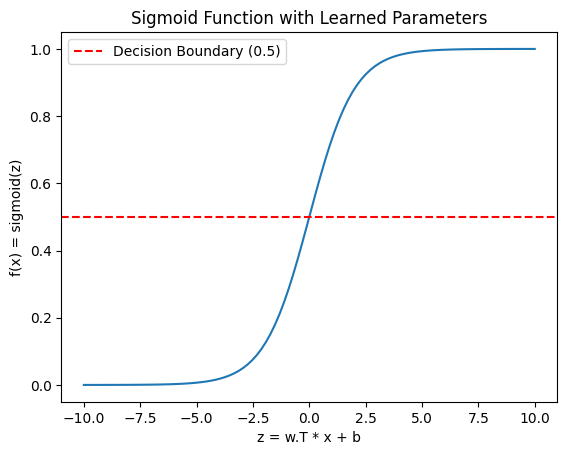

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special  # For sigmoid function

def sigmoid(x):
    return scipy.special.expit(x)

def plot_sigmoid_with_params(w, b):
    z_values = np.linspace(-10, 10, 100)
    sigmoid_outputs = sigmoid(z_values)

    plt.plot(z_values, sigmoid_outputs)
    plt.xlabel("z = w.T * x + b")
    plt.ylabel("f(x) = sigmoid(z)")
    plt.title("Sigmoid Function with Learned Parameters")

    # Indicate decision boundary (0.5)
    plt.axhline(y=0.5, color='r', linestyle='--', label="Decision Boundary (0.5)")
    plt.legend()
    plt.show()

# Assuming 'd' contains the model parameters:
plot_sigmoid_with_params(d["w"], d["b"])

In [ ]:
#print save the parameters
import pickle
with open('parameters.pkl', 'wb') as f:
    pickle.dump(d, f)


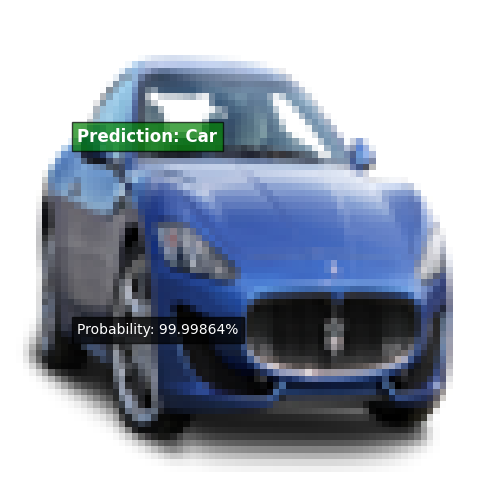

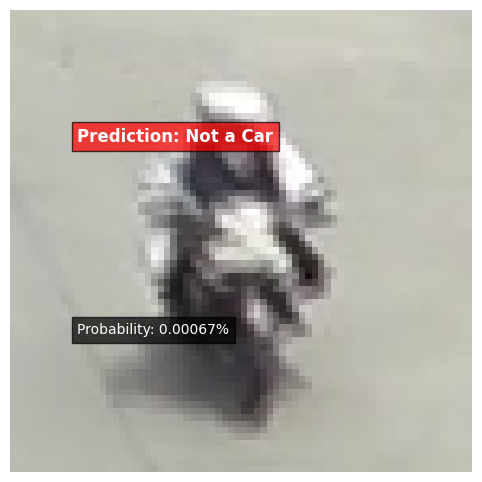

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle


with open('parameters.pkl', 'rb') as f:
    p = pickle.load(f)

def sigmoid(z):
    """
    Compute the sigmoid of z
    """
    return 1 / (1 + np.exp(-z))

def predict_from_png(image_path, w = p["w"], b = p["b"]):
    """
    Given any png image path it predicts whether it's a car or not

    Arguments:
    image_path -- path to the image
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """

    img = Image.open(image_path)
    img = img.resize((72, 72))
    img_array = np.array(img)

    img_array = img_array / 255.0

    Y_prediction = sigmoid(np.dot(w.T, img_array.reshape(72 * 72 * 4, 1)) + b)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')

    isCar = Y_prediction > 0.5

    Pred_Probablity = Y_prediction[0][0] * 100

    prediction_text = "Prediction: Car" if isCar else "Prediction: Not a Car"
    probability_text = f"Probability: {Pred_Probablity:.5f}%"

    plt.text(10, 20, prediction_text, color='white',
             fontsize=12, fontweight='bold',
             bbox=dict(facecolor='green' if isCar else 'red', alpha=0.7))
    plt.text(10, 50, probability_text, color='white',
             fontsize=10,
             bbox=dict(facecolor='black', alpha=0.7))

    plt.show()



predict_from_png("/content/car.png")
predict_from_png("/content/carnoncar-dataset/non_car_scaled/non_car_scaled/scaled_25.png")